# Plot rank maps of along-track data
* stephanie.leroux@ocen-next.fr
* This notebook reads the "rank" dataset computed with the sesam software, and plot different things: 
    - Plot rank map for a given  10-d time segment
    - Plot map of the mean rank over the entire period (2008-2015)
    - Compute the number of occurences where the obs is out of the model distribution (rank =0 or 1)
* For more explanation on what those diagnostics and plots mean, you can also read the associated report (pdf document). 
* _Python/xarray note:_ This notebook takes advantage of the xarray.groupby fonctionnality, which allows to process and apply some simple operations (mean, min, max) very efficiently on the alongtrack data grouped by location. This approach is much more efficient than looping explicitely  on the enire along track data. 

# Imports

In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from jdcal import gcal2jd, jd2gcal

%matplotlib inline 

# Define some functions for plot purposes

In [2]:
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap


In [3]:
def plotmapSCATT(fig1,ehonan,nav_lon,nav_lat,cm_base,vmin,vmax,Nincr,plto,glo=True,coastL=False,coastC=False,xlim=(0,10),ylim=(0,10),su='b',so='k',loncentr=0.,outonly=False, inonly=False):
        '''
        
        Plot regional or global map of scatter data (point by point data).
        Uses Cartopy.
        Parameters: (...to be done...)

        '''
        
        ## imports
        import os,sys
        import numpy as np

        # xarray
        import xarray as xr

        # plot
        import cartopy.crs as ccrs
        import cartopy.feature as ccf
        import matplotlib.pyplot as plt
        from matplotlib.colors import Colormap
        import matplotlib.colors as mcolors
        import matplotlib.dates as mdates
        import matplotlib.cm as cm
        import matplotlib.dates as mdates
        import matplotlib.ticker as mticker
        
        # Colormap & levels
        cmap = plt.get_cmap(cm_base)
        cmap.set_under(su,1.)
        cmap.set_over(so,1.) 
        levels = mticker.MaxNLocator(nbins=Nincr).tick_values(vmin, vmax)
        norm   = mcolors.BoundaryNorm(levels, ncolors=cmap.N)
        
        # Projection
        
        trdata  = ccrs.PlateCarree() 
        # Note: if data points are given in classical lat lon coordinates this should
        #       be set to ccrs.PlateCarree() whatever the map projection is.
        
        if glo:
            ax = plt.axes(projection=ccrs.Robinson(central_longitude=loncentr))
            # marker size
            sm=0.1
        else:
            ax = plt.axes(projection= ccrs.PlateCarree())
            # marker size
            sm=0.5
        
        if glo:
            ax.set_global() 
            
        if glo:
            ax.outline_patch.set_edgecolor('#585858')
        else:
            ax.outline_patch.set_edgecolor('white')
            

        # grid on map
        if glo:
            gl = ax.gridlines(linewidth=1, color='#585858', alpha=0.2, linestyle='--') 
        else:
            gl = ax.gridlines(draw_labels=True,linewidth=1, color='#585858', alpha=0.2, linestyle='--')
            # grid labels
            label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}
            gl.xlabel_style = label_style
            gl.xlabels_bottom = False
            gl.xlocator = mticker.FixedLocator(np.arange(-180,180,20,dtype=float))
            gl.ylabel_style = label_style
            gl.ylabels_right = False
            gl.ylocator = mticker.FixedLocator(np.arange(-90,90,20,dtype=float))
       
        # Add Coastlines and or plain continents
        if coastC:
            ax.add_feature(ccf.LAND, facecolor='#585858', edgecolor='none')
        if coastL:
            ax.coastlines(color='#585858')
        
        ### PLOTS:
        
        if inonly==False:
            # plot points where rank is 0
            cs2 = plt.scatter(nav_lon.where(ehonan==0.), nav_lat.where(ehonan==0.), s=sm, marker="D",color=su,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            # plot points where rank is 1
            cs3 = plt.scatter(nav_lon.where(ehonan==1.), nav_lat.where(ehonan==1.), s=sm,  marker="D",color=so,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            # plot points where rank is different from 0 and 1 (true obs in the model pdf)
        
        if outonly==False:
            cs = plt.scatter(nav_lon.where((ehonan!=1.)&(ehonan!=0.)), nav_lat.where((ehonan!=1.)&(ehonan!=0.)), s=sm, marker="D", c=ehonan.where((ehonan!=1.)&(ehonan!=0.)), cmap=cmap,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
            ###cs = plt.scatter(nav_lon, nav_lat, s=sm, marker="D", c=ehonan, cmap=cmap,transform=trdata,norm=norm,vmin=vmin,vmax=vmax)
        
        if glo==False:
            #limits
            plt.xlim(xlim)
            plt.ylim(ylim) 

        # plot colorbar
        cb = plt.colorbar(cs, extend='both',  pad=0.04, orientation='horizontal', shrink=0.75)
        cb.ax.tick_params(labelsize=15) 
        cb.set_label(labelplt,size=15)
        ticks = np.linspace(vmin,vmax,11)
        cb.set_ticks(ticks)
        new_tickslabels = ["%.2f" % i for i in ticks]
        cb.set_ticklabels(new_tickslabels)

# Data parameters

In [4]:
# data dirtectory
diri = "/mnt/meom/workdir/lerouste/Sesam/Cfg_SSH_trueobs_10ds/RANK50/"

# directory where to save plots
diro='./plots/'

# name of variable in .cobs files (from Sesam)
varna='JASON'

# TIME coordinate:
# cnes reference julian date 
cnesjdref = 2433282.5 
# will use package jdcal to convert julian days to dates


# unit to appear in plot title
unitna = 'm'

# output res and format
dpifig=150
pltty = ".png"

# Make custom colormap

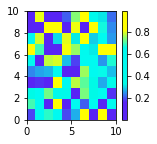

In [5]:
### colors to include in my custom colormap
#colors=[(255,255,0),(255,255,0),(250,0,0),(255,0,0),(250,0,0),(88,36,245),(88,36,245)]
colors=[(255,255,0),(255,255,0),(0,250,240),(0,250,240),(0,250,230),(88,36,245),(88,36,245)]
#colors=[(169,247,242),(169,247,242),(200,254,46),(200,254,46),(200,254,46),(8,75,138),(8,75,138)]

### Call the function make_cmap which returns my colormap
my_cmap = make_cmap(colors[::-1], bit=True)

### Display my colormap
plotcolormap=True
if plotcolormap:
    fig = plt.figure(figsize=([2,2]),facecolor='white')
    #ax = fig.add_subplot(311)
    plt.pcolor(np.random.rand(10,10), cmap=my_cmap)
    plt.colorbar()
    plt.show() 
    plt.close(fig) 


--- 
# Rank maps for a given 10-d time segment

## - Read the given time segment

In [6]:
# time segment
seg =  23741 
print('---'+str(seg))

# name of input directory
namdir = 'RANK50ERROBS_'+str(seg)+'_0011/'

# read corresponding lat, lon and ranks
lon = xr.open_dataset(diri+namdir+'rank_JASON.cobs')['lon'] 
lat = xr.open_dataset(diri+namdir+'rank_JASON.cobs')['lat'] 
rank =xr.open_dataset(diri+namdir+'rank_JASON.cobs')[varna] 

# convert time segment in a calendar date
DATE = jd2gcal(seg+4,cnesjdref)

#print(DATE)
# note: +4 is  by convention to set the date to the middle of the 10d period 
datena= str(DATE[0])+'-'+str(DATE[1])+'-'+str(DATE[2])
print(datena)

---23741
2015-1-5


## - Set plot parameters

In [7]:

#------ PLOT PARAMETERS ---------------
# colormap
cm_base=my_cmap  

# min/max values
vmin=0.
vmax=1.
Nincr=100

# central longitude (for global map)
loncentr=180

# data to plot: rank
data2plot = rank.squeeze()

# plot title and output file title
plti="rank_obsERROBS"
labelplt= plti+' '+datena

## - Regional map

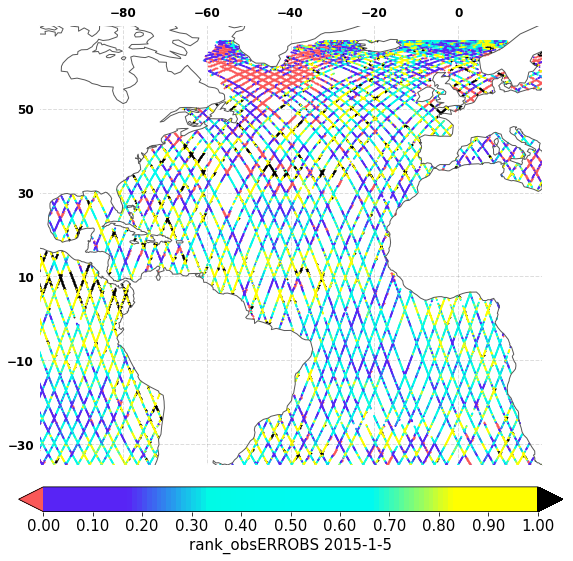

In [15]:
plto = "NATL60_SLA."+plti+'_'+str(DATE[0])


#create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon,lat,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=False,coastL=True,coastC=False,su='#FA5858',so='k') #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  

## - Global map

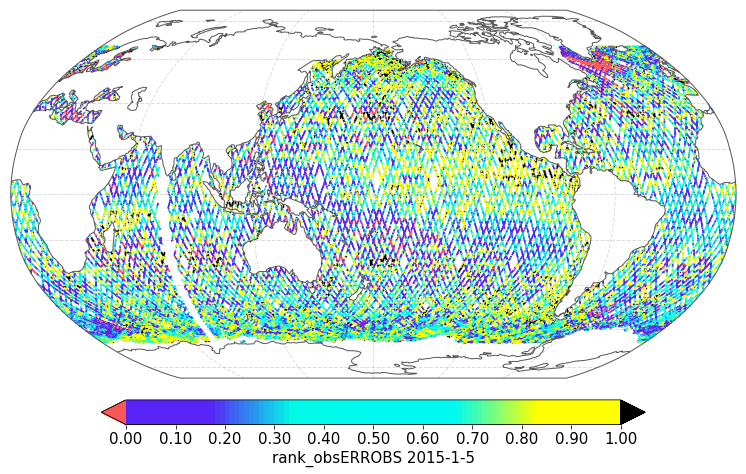

In [14]:
plto = "GLOB180_SLA."+plti+'_'+str(DATE[0])


# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon,lat,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='#FA5858',so='k')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

<hr><hr/>
# Mean rank map

## - Read all data with xarray

In [17]:
alllon   = xr.open_mfdataset(diri+'RANK50ERROBS_?????_0011/rank_JASON.cobs',concat_dim='obsidx',decode_times=False)['lon']
alllat   = xr.open_mfdataset(diri+'RANK50ERROBS_?????_0011/rank_JASON.cobs',concat_dim='obsidx',decode_times=False)['lat'] 
allrank  = xr.open_mfdataset(diri+'RANK50ERROBS_?????_0011/rank_JASON.cobs',concat_dim='obsidx',decode_times=False)[varna]

In [18]:
# rewrite data as xarrays with lat as coordinate (this will then permit to group the rank array by latitude values):
xrrank =  xr.DataArray(allrank.values,coords=[alllat], dims=['lat'],name=varna)
xrlat =   xr.DataArray(alllat.values,coords=[alllat], dims=['lat'],name='lati')
xrlon =   xr.DataArray(alllon.values,coords=[alllat], dims=['lat'],name='lon')

## - Compute time-mean rank and associated coordinates

In [19]:
# time-mean rank over the entire period 2009-2015
TMrank    = xrrank.groupby('lat').mean()

In [20]:
# store number of occurrences at each location
occurrences = xrrank.groupby('lat').count()

# make it an xarray again for later use
occurrences = xr.DataArray(occurrences,name='TMoccurrences')

In [21]:
# Proceed the same way with the latitude array ...
TMlat    =  xrlat.groupby('lat').mean()

# ... and the longitude array
TMlon    =  xrlon.groupby('lat').mean()

# ...and also compute min and max longitude for later check (see explanation just below)
MINlon =  xrlon.groupby('lat').min()
MAXlon =  xrlon.groupby('lat').max()


### - Checking the ```groupby``` approach


#### Note: 
The difference MAXlon-MINlon will be computed as a check: xrrank is grouped by identical **latitude** values. In the along-track context, these latitude values should almost each  correspond to a unique along-track location around the globe (meaning a given lat value always corresponds to the same longitude value). As a check, and to eliminate the few latitudes for which the above is not true, we use the longitude array,  also grouped by its latitude coordinate. If the above statement is true, then MAXlon - MINlon should be 0. It is mostly the case but there are about 1% of the points where it is not true (meaning a few latitude values can correspond to different longitude values). We thus discard those points before diagnostics and plots._

In [22]:
# check (see explanation below)
difflon =  MAXlon - MINlon

print('---removed points (%):')
Ndiff = difflon.where(difflon!=0,drop=True).size
Ntot = difflon.size
print(Ndiff*100/Ntot)

---removed points (%):
1.108594140341782


## - Plot global map of mean rank

2009-2015


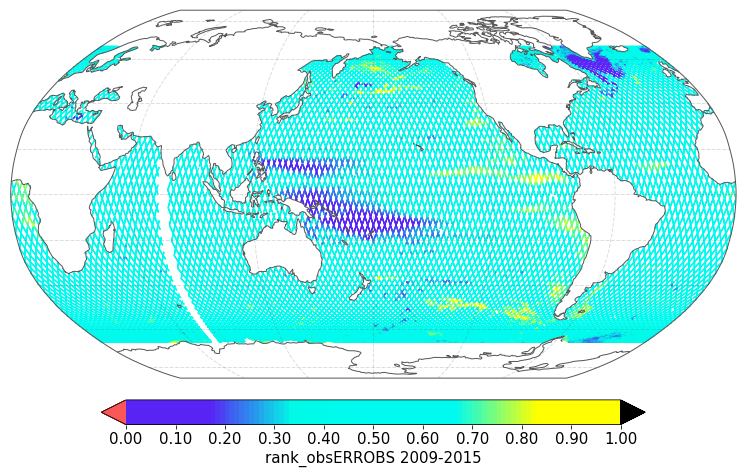

In [23]:
datena= '2009-2015'
print(datena)

# colormap
cm_base=my_cmap  #'Spectral_r'#cm_base=my_cmap #
# min/max values
vmin=0.
vmax=1.
Nincr=100
loncentr=180
cmap = plt.get_cmap(cm_base)
cmap


# data to plot:
data2plot = TMrank.where(difflon==0,drop=True).squeeze()
lat2plot  = TMlat.where(difflon==0,drop=True).squeeze()
lon2plot  = MINlon.where(difflon==0,drop=True).squeeze() 



plti="rank_obsERROBS"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= plti+' '+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='#FA5858',so='k')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

## - Regional map of mean rank

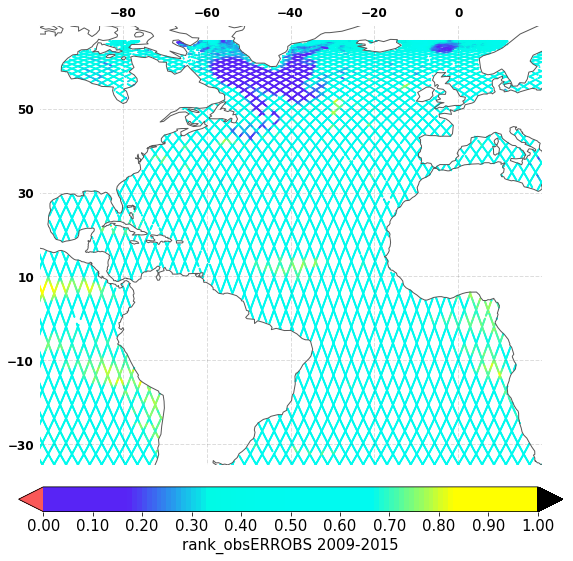

In [24]:
data2plot = TMrank.where(difflon==0,drop=True).squeeze()
lat2plot = TMlat.where(difflon==0,drop=True).squeeze()
lon2plot = MINlon.where(difflon==0,drop=True).squeeze() 

# plot title and output file title
plti="rank_obsERROBS"
plto = "NATL60_SLA."+plti+'_'+datena
labelplt= plti+' '+datena

#------ START PLOTTING ------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=False,coastL=True,coastC=False,su='#FA5858',so='k') #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  

## - Plot number of occurrences

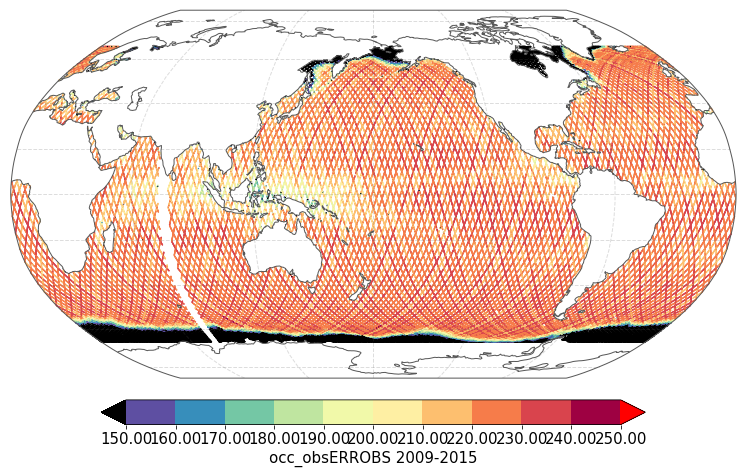

In [46]:
# colormap
cm_base='Spectral_r' #my_cmap  #'Spectral_r'#cm_base=my_cmap #
# min/max values
vmin=150.
vmax=250.
Nincr=10
loncentr=180
cmap = plt.get_cmap(cm_base)

data2plot = occurrences.where(difflon==0,drop=True).squeeze()
lat2plot = TMlat.where(difflon==0,drop=True).squeeze()
lon2plot = MINlon.where(difflon==0,drop=True).squeeze() 

plti="occ_obsERROBS"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= plti+' '+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r',inonly=True)   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

<hr><hr/>
# Percentage of occurrences when the obs is out of the model distribution (i.e. when rank is either 0 or 1)

## - Case rank=0

In [25]:
# Set all occurrences where rank=0 to 100. :
xrrank0only = xrrank.where(xrrank!=0,other=100.) 

# Set values other than 100 to 0
xrrank0only =  xrrank0only.where(xrrank0only==100,other=0)

# Compute mean value per latitude
# (this is a proxy for the % of occurrences where rank=0 at each location)
percR0 = xrrank0only.groupby('lat').mean()

# select only the locations where more than 150 occurrences are cumulated
percR0_select = xrrank0only.groupby('lat').mean().where(occurrences>150)

## - Case rank=1

In [27]:
# Set all occurrences where rank=0 to 100. :
xrrank1only = xrrank.where(xrrank!=1,other=100.) 

# Set values other than 100 to 0
xrrank1only =  xrrank1only.where(xrrank1only==100,other=0)

# Compute mean value per latitude
# (this is a proxy for the % of occurrences where rank=0 at each location)
percR1 = xrrank1only.groupby('lat').mean()

# select only the locations where more than 150 occurrences are cumulated
percR1_select = xrrank1only.groupby('lat').mean().where(occurrences>150)

## - GLOBAL maps

* __Plot parameters__

In [28]:
datena= '2009-2015'
print(datena)

# colormap
# colormap
cm_base='Spectral_r' #my_cmap  #'Spectral_r'#cm_base=my_cmap #
# min/max values

loncentr=180
cmap = plt.get_cmap(cm_base)
cmap

2009-2015


* __Case Rank=1__

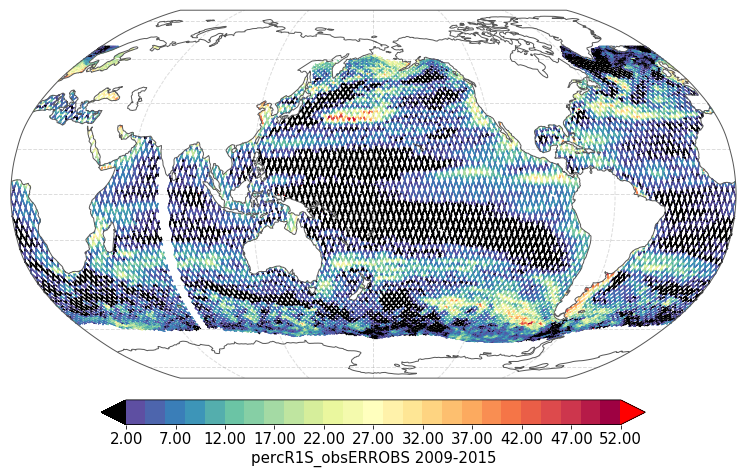

In [33]:
vmin=2.
vmax=52.
Nincr=25

data2plot = percR1_select.where(difflon==0,drop=True).squeeze()
lat2plot = TMlat.where(difflon==0,drop=True).squeeze()
lon2plot = MINlon.where(difflon==0,drop=True).squeeze() 

plti="percR1S_obsERROBS"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= plti+' '+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

* Case Rank=0

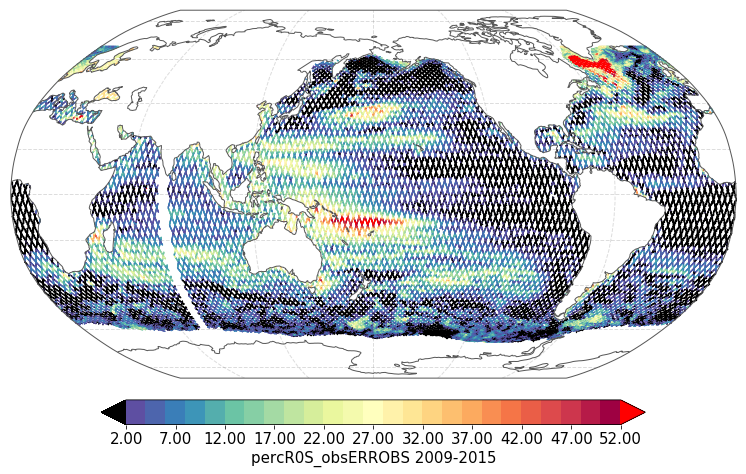

In [37]:
vmin=2.
vmax=52.
Nincr=25

data2plot = percR0_select.where(difflon==0,drop=True).squeeze()
lat2plot = TMlat.where(difflon==0,drop=True).squeeze()
lon2plot = MINlon.where(difflon==0,drop=True).squeeze() 

plti="percR0S_obsERROBS"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= plti+' '+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)       

* Case Rank=0 or 1

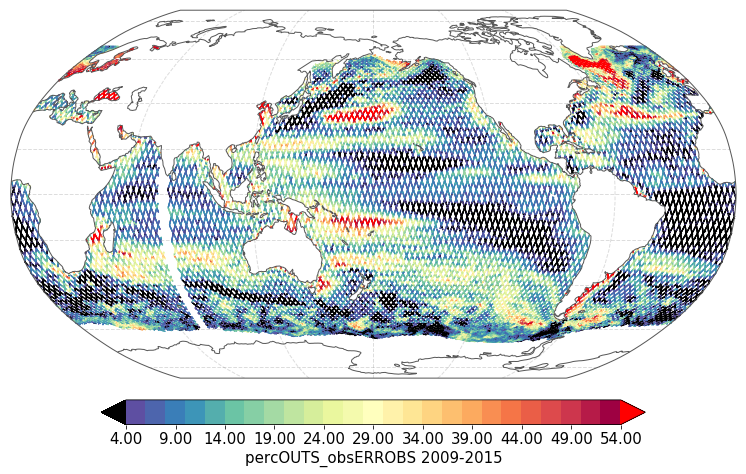

In [35]:
vmin=4.
vmax=54.
Nincr=25

data2plot = percR1_select.where(difflon==0,drop=True).squeeze()+percR0_select.where(difflon==0,drop=True).squeeze()
lat2plot = TMlat.where(difflon==0,drop=True).squeeze()
lon2plot = MINlon.where(difflon==0,drop=True).squeeze() 

plti="percOUTS_obsERROBS"
plto = "GLOB180_c"+"_SLA."+plti+'_'+datena
labelplt= plti+' '+datena

#------ START PLOTTING-----------------------------------------------------------------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data (base plot)
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,plto=plto,glo=True,loncentr=loncentr,coastL=True,su='k',so='r')   
plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)    

## Regional maps

* Case (R=1 or R=0) 

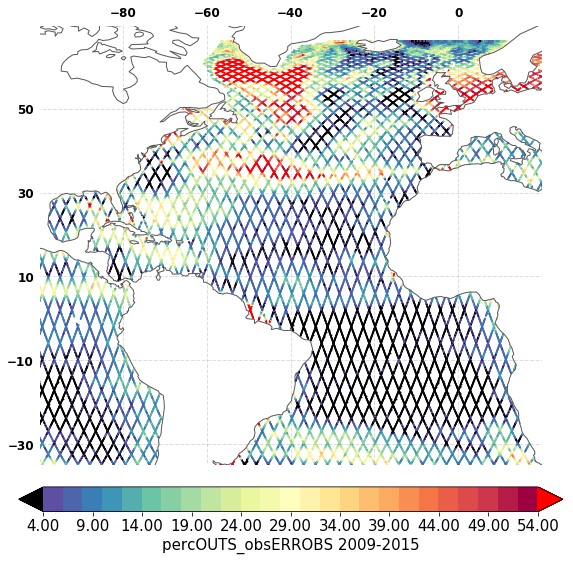

In [36]:
vmin=4.
vmax=54.
Nincr=25

data2plot = percR1_select.where(difflon==0,drop=True).squeeze()+percR0_select.where(difflon==0,drop=True).squeeze()
lat2plot = TMlat.where(difflon==0,drop=True).squeeze()
lon2plot = MINlon.where(difflon==0,drop=True).squeeze() 

#plot title and output file title
plti="percOUTS_obsERROBS"
plto = "NATL60_SLA."+plti+'_'+datena
labelplt= plti+' '+datena



#------ START PLOTTING ------------
# create fig
fig1 = plt.figure(figsize=([13,10]),facecolor='white')

# plot data 
css =  plotmapSCATT(fig1,data2plot,lon2plot,lat2plot,cm_base=cm_base,vmin=vmin,vmax=vmax,Nincr=Nincr,xlim=(-100,20),ylim=(-35,70) ,plto=plto,glo=False,coastL=True,coastC=False,su='k',so='r') #, 

plt.show()

# Save fig in png, resolution dpi
fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0)#
plt.close(fig1)  